In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from umap import UMAP

2022-07-12 23:57:16.373613: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
df = pd.read_csv('german_credit_data.csv').drop(['Unnamed: 0'], axis=1)

In [3]:
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,male,2,own,NaN,little,1169,6,radio/TV
1,22,female,2,own,little,moderate,5951,48,radio/TV
2,49,male,1,own,little,NaN,2096,12,education
3,45,male,2,free,little,little,7882,42,furniture/equipment
4,53,male,2,free,little,little,4870,24,car


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
dtypes: int64(4), object(5)
memory usage: 70.4+ KB


In [5]:
from sklearn.preprocessing import OrdinalEncoder

def encode_func(data, enc, cols = ['Sex', 'Housing', 'Job', 'Saving accounts', 'Checking account', 'Purpose']):
    data_enc = data.copy()
    data_enc[cols]= enc.fit_transform(data_enc[cols])
    return data_enc

# Пустые значения заполним нулями, это пригодится далее
df = df.fillna(-9999)

# попробуем пронумеровать по возрастанию значения типа 'little', 'rich' и т.д.
df['Checking account'] = df['Checking account'].replace(['little','moderate','rich'], [0, 1, 2])
df['Saving accounts'] = df['Saving accounts'].replace(['little','moderate','quite rich', 'rich'], [0, 1, 2, 3])
# Допустим мы оцениваем вероятность того, что клиента НЕ ждёт дефолт, т.е. он будет достаточно платёжеспособен.
# Меньшим весом будет обладать тот человек, который снимает жилье, затем, который имеет собственное, 
# а затем, который имеет бесплатное.
df['Housing'] = df['Housing'].replace(['rent','own', 'free'], [0, 1, 2])
df = pd.get_dummies(df, prefix=['Sex'], columns = ['Sex'])

In [6]:
df.head()

,Age,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Sex_female,Sex_male
0,67,2,1,-9999,0,1169,6,radio/TV,0,1
1,22,2,1,0,1,5951,48,radio/TV,1,0
2,49,1,1,0,-9999,2096,12,education,0,1
3,45,2,2,0,0,7882,42,furniture/equipment,0,1
4,53,2,2,0,0,4870,24,car,0,1


In [7]:
# Посмотрим среднюю величину кредита в зависимости от категории покупки
purposes_means = []
for purpose in df['Purpose'].unique():
    res = purpose, np.mean(df[df['Purpose'] == purpose]['Credit amount'])
    print(res)
    purposes_means.append(res)

('radio/TV', 2487.6535714285715)
('education', 2879.2033898305085)
('furniture/equipment', 3066.988950276243)
('car', 3768.192878338279)
('business', 4158.041237113402)
('domestic appliances', 1498.0)
('repairs', 2728.090909090909)
('vacation/others', 8209.333333333334)


In [8]:
# Пронумеруем Purpose в зависимости от средней величины кредита
purposes_means = np.array(purposes_means)
sorted_purposes = purposes_means[purposes_means[:, 1].argsort()][:, 0]
df['Purpose'] = df['Purpose'].replace(sorted_purposes, [i+1 for i in range(len(sorted_purposes))])

In [9]:
df.head()

,Age,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Sex_female,Sex_male
0,67,2,1,-9999,0,1169,6,2,0,1
1,22,2,1,0,1,5951,48,2,1,0
2,49,1,1,0,-9999,2096,12,4,0,1
3,45,2,2,0,0,7882,42,5,0,1
4,53,2,2,0,0,4870,24,6,0,1


In [10]:
# Используем StandardScaler для нормализации данных
scaler = StandardScaler()
scaled_data = pd.DataFrame(
    data=scaler.fit_transform(df), 
    columns=df.columns
)

/home/yaroslav/.conda/envs/my-ml-env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/yaroslav/.conda/envs/my-ml-env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


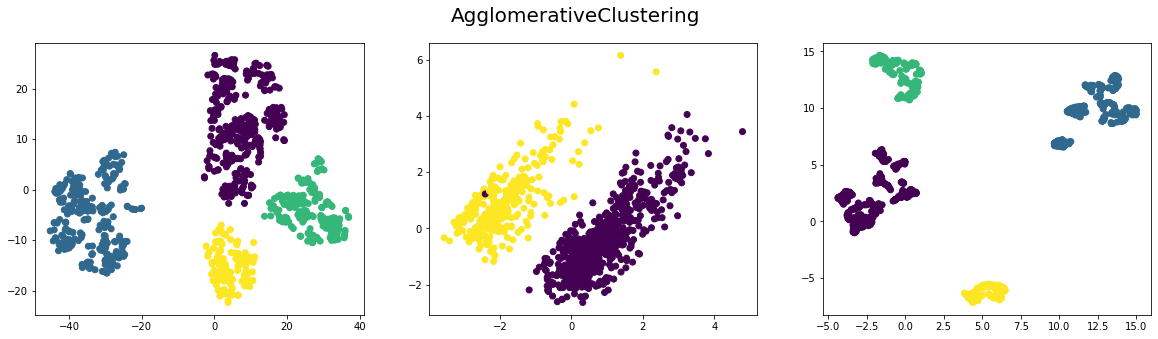

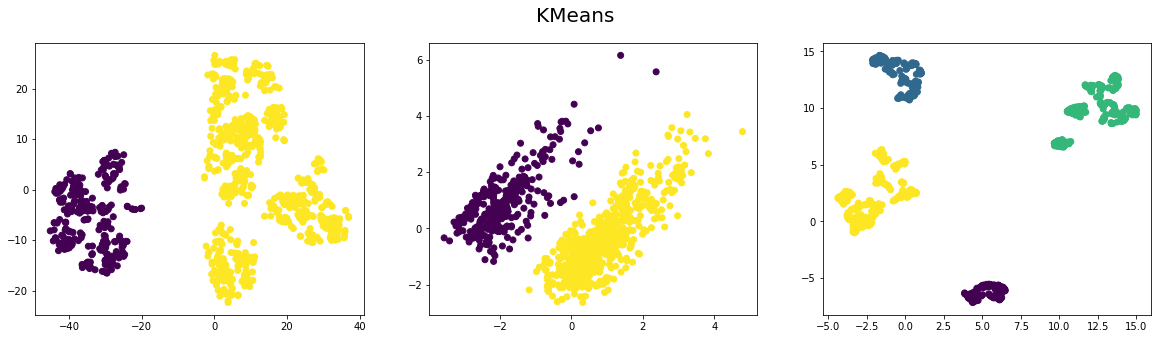

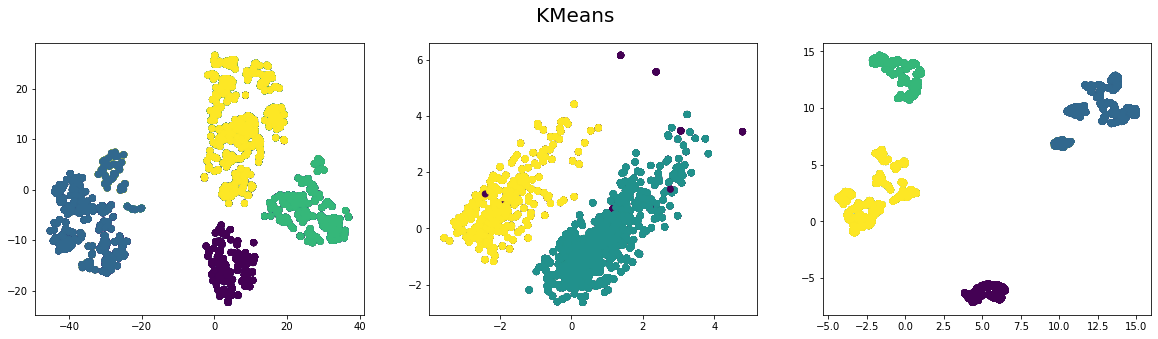

In [17]:
# Создадим цикл, перебирающий алгоритмы кластеризации, выбор оптимального количества кластеров и алгоритмы снижения размерности
clustering_algorithms = [AgglomerativeClustering, KMeans]
df_labels = pd.DataFrame()
n_clusters_list = [i for i in range(2, 21)]


tsne = TSNE(perplexity=50, n_jobs=-1, random_state=42)
tsne_transformed = tsne.fit_transform(scaled_data)

pca = PCA(random_state=42)
pca_transformed = pca.fit_transform(scaled_data)

umap = UMAP(random_state=42)
umap_transformed = umap.fit_transform(scaled_data)

for algorithm in clustering_algorithms:
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    for ind, dim_reduced_data in enumerate([tsne_transformed, pca_transformed, umap_transformed]):
        silhouette = []
        inertia = []
        for i in n_clusters_list:
            model = algorithm(n_clusters=i).fit(dim_reduced_data)
            labels = model.labels_
            score = silhouette_score(dim_reduced_data, labels)
            silhouette.append(score)
        
        model = algorithm(n_clusters=n_clusters_list[np.argmax(silhouette)]).fit(dim_reduced_data)
        labels = model.labels_
        df_labels[algorithm.__name__] = model.labels_
        plt.suptitle(algorithm.__name__, fontsize=20)
        axes[ind].scatter(dim_reduced_data[:, 0], dim_reduced_data[:, 1], c=labels)
        

# DBSCAN сам задаёт кол-во кластеров
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
for ind, dim_reduced_data in enumerate([tsne_transformed, pca_transformed, umap_transformed]):
    silhouette = []
    clusters = []
    eps_range = np.arange(0.1,4,0.1)
    for i in eps_range:
        dbscan = DBSCAN(eps=i).fit(dim_reduced_data)
        labels = dbscan.labels_
        uniq_labels = np.unique(labels)
        n_clusters = len(uniq_labels[uniq_labels != -1])
        if n_clusters > 1:
            score = silhouette_score(dim_reduced_data, labels)
        else:
            score = 0
        silhouette.append(score)
        clusters.append(n_clusters)
        model = DBSCAN(eps=eps_range[np.argmax(silhouette)]).fit(dim_reduced_data)
        labels = model.labels_
        df_labels[algorithm.__name__] = model.labels_
        plt.suptitle(algorithm.__name__, fontsize=20)
        axes[ind].scatter(dim_reduced_data[:, 0], dim_reduced_data[:, 1], c=labels)

In [ ]:
df_labels.head()

In [ ]:
alg = 'AgglomerativeClustering'
df = df.join(df_labels[alg])